In [1]:
import cgi
import getpass
import io
import os
import pandas as pd
import pathlib
import requests
import seaborn as sns
import shutil
import subprocess
import tempfile
import zipfile

from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

gateway_url = "https://md.cybershuttle.org"
vmd_scripts = pathlib.Path('.') / 'vmd_scripts'
VMD_EXECUTABLE = 'vmd_MACOSXARM64'

In [4]:
# DEBUGGING

# import http.client as http_client
# http_client.HTTPConnection.debuglevel = 1
# import logging

# # You must initialize logging, otherwise you'll not see debug output.
# logging.basicConfig()
# logging.getLogger().setLevel(logging.DEBUG)
# requests_log = logging.getLogger("requests.packages.urllib3")
# requests_log.setLevel(logging.DEBUG)
# requests_log.propagate = True

In [2]:
import webbrowser

webbrowser.open(f"{gateway_url}/auth/login-desktop/?show-code=true")

True

In [3]:
access_token = getpass.getpass()

 ········


In [4]:
def download_experiment(experiment_id):
    headers = {'Authorization': f'Bearer {access_token}'}
    r = requests.get(f'{gateway_url}/sdk/download-experiment-dir/{experiment_id}/', headers=headers)
    r.raise_for_status()
    # get name of zip file as returned in HTTP response headers and name the output directory the same
    disposition = r.headers['Content-Disposition']
    disp_value, disp_params = cgi.parse_header(disposition)
    filename, ext = os.path.splitext(disp_params['filename'])
    output_dir = pathlib.Path(filename)
    
    zipped = zipfile.ZipFile(io.BytesIO(r.content))
    zipped.extractall(output_dir)
    return output_dir

In [5]:
# experiment_id = "Clone_of_NAMD_on_Jun_29,_2023_4:59_PM_0b3db6e0-782c-4aeb-af04-f631579d0ad8"

experiment_id = "Clone_of_Clone_of_NAMD_on_May_27,_2023_2:36_PM_2d2b7565-1936-469e-9467-e81f9671e284"

In [6]:
experiment_dir = download_experiment(experiment_id)

In [56]:
def run_vmd_script(script_name:str, output_filename:str, data_dir:pathlib.Path, psf_name="*.psf", dcd_name="*.dcd", output_dir=None):
    with tempfile.TemporaryDirectory() as tmpdirname:
        psf_filepath = next(data_dir.glob(psf_name))  # just get the first matching one
        dcd_filepath = next(data_dir.glob(dcd_name))
        shutil.copy(psf_filepath, tmpdirname + "/protein.psf")
        shutil.copy(dcd_filepath, tmpdirname + "/smooth_protein.dcd")

        args = [VMD_EXECUTABLE, '-dispdev', 'text', '-e', os.fspath((vmd_scripts / script_name).absolute())]
        # print(args)
        subprocess.run(args, check=True, cwd=tmpdirname, capture_output=True)

        if output_dir is None:
            output_dir = data_dir
        else:
            output_dir = pathlib.Path(output_dir)
        shutil.copy(os.path.join(tmpdirname, output_filename), output_dir / output_filename)
        

In [57]:
experiment_1r17_dir = pathlib.Path('./1r17/run/')

In [59]:
run_vmd_script('rmsd.tcl', 'rmsd.dat', experiment_1r17_dir, psf_name="protein.psf", dcd_name="smooth_protein.dcd")

# run_vmd_script('rmsd.tcl', 'rmsd.dat', experiment_dir)

# RMSD

In [62]:
df = pd.read_csv(experiment_1r17_dir / 'rmsd.dat', header=None, names=['all'])


<Axes: >

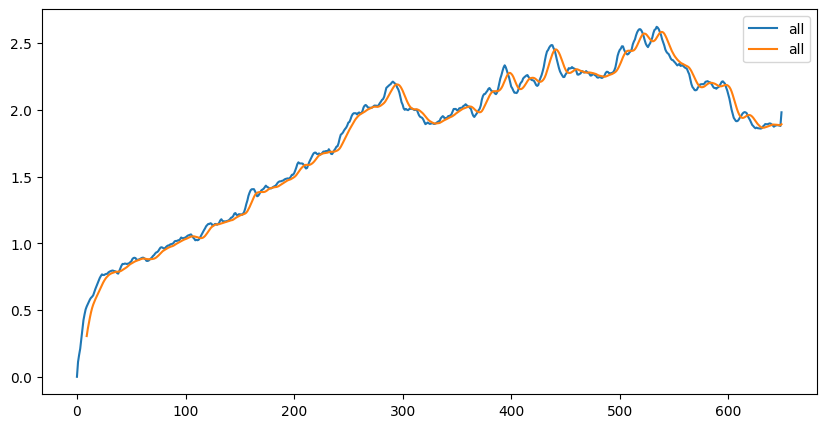

In [63]:
fig,ax=plt.subplots(figsize=(10,5))
df.plot(y='all',ax=ax)
df.rolling(10).mean().plot(y='all',ax=ax)

# Energy profile

In [7]:
log_file = experiment_dir / 'NAMD.stdout'

energies_data = io.StringIO()
with open(log_file, 'r') as f:
    for line in f:
        if line.startswith("ENERGY:"):
            energies_data.write(line)
energies_data.seek(0)

energies = pd.read_csv(energies_data, sep='\s+', header=None)


In [8]:
energies.rename(columns={1: 'TS', 13:'Potential', 12: 'Temperature', 16: 'Pressure'}, inplace=True)
# energies

Text(0.5, 0, 'Timestep')

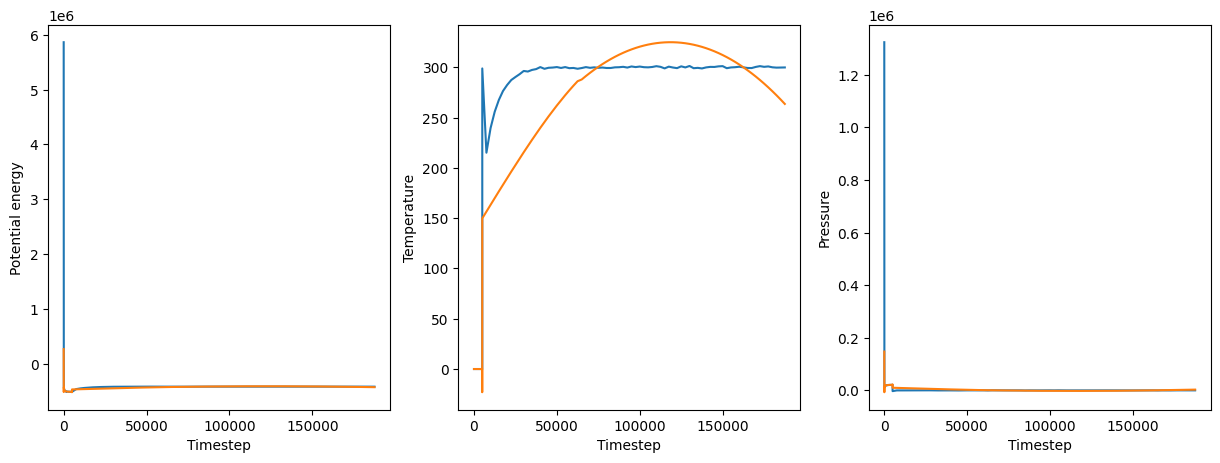

In [9]:
fig,ax = plt.subplots(ncols=3,figsize=(15,5),
                      sharex=True,sharey=False)

ax[0].plot(energies['TS'],energies['Potential'])
ax[1].plot(energies['TS'],energies['Temperature'])
ax[2].plot(energies['TS'],energies['Pressure'])

# Some signal processing
ax[0].plot(energies['TS'],savgol_filter(energies['Potential'],100,2))
ax[1].plot(energies['TS'],savgol_filter(energies['Temperature'],100,2))
ax[2].plot(energies['TS'],savgol_filter(energies['Pressure'],100,2))

ax[0].set_ylabel('Potential energy')
ax[1].set_ylabel('Temperature')
ax[2].set_ylabel('Pressure')

ax[0].set_xlabel('Timestep')
ax[1].set_xlabel('Timestep')
ax[2].set_xlabel('Timestep')